# Étape 1 :Préparation et Organisation du Jeu de Données

In [4]:
import pandas as pd
import os
import shutil
from PIL import Image, ImageOps
import random

# Chemins source
dataset_path = 'Dataset'
csv_train_path = os.path.join(dataset_path, 'train.csv')
csv_test_path = os.path.join(dataset_path, 'test.csv')
image_folder_src = os.path.join(dataset_path, 'images')

# Chemins de destination
output_dir = 'Dataset_Préparer'
data_train_dir = os.path.join(output_dir, 'Data_Train')
data_test_dir = os.path.join(output_dir, 'Data_Test')
train_images_dir = os.path.join(data_train_dir, 'images_train')
test_images_dir = os.path.join(data_test_dir, 'images_test')
healthy_dir = os.path.join(data_train_dir, 'Feuilles_Healthy')
malade_dir = os.path.join(data_train_dir, 'Feuilles_Malades')

# Création des dossiers nécessaires
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(malade_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

# Charger le fichier CSV train
df_train = pd.read_csv(csv_train_path)

# Séparer les données saines et malades
df_saines = df_train[df_train['healthy'] == 1]
df_malades = df_train[df_train['healthy'] == 0]

# Copier train.csv dans Data_Train
shutil.copy(csv_train_path, os.path.join(data_train_dir, 'train.csv'))

# Copier les images d'entraînement vers images_train
for image_id in df_train['image_id']:
    src = os.path.join(image_folder_src, f'{image_id}.jpg')
    dst = os.path.join(train_images_dir, f'{image_id}.jpg')
    if os.path.exists(src):
        shutil.copy(src, dst)

# Copier les images saines et malades dans leurs dossiers respectifs
for image_id in df_saines['image_id']:
    src = os.path.join(train_images_dir, f'{image_id}.jpg')
    dst = os.path.join(healthy_dir, f'{image_id}.jpg')
    if os.path.exists(src):
        shutil.copy(src, dst)

for image_id in df_malades['image_id']:
    src = os.path.join(train_images_dir, f'{image_id}.jpg')
    dst = os.path.join(malade_dir, f'{image_id}.jpg')
    if os.path.exists(src):
        shutil.copy(src, dst)

# Copier test.csv et images de test
df_test = pd.read_csv(csv_test_path)
shutil.copy(csv_test_path, os.path.join(data_test_dir, 'test.csv'))

for image_id in df_test['image_id']:
    src = os.path.join(image_folder_src, f'{image_id}.jpg')
    dst = os.path.join(test_images_dir, f'{image_id}.jpg')
    if os.path.exists(src):
        shutil.copy(src, dst)

# -------------------------------
# ÉQUILIBRAGE PAR AUGMENTATION
# -------------------------------

# Définir combien d’images saines on veut ajouter
nb_images_saines_orig = len(os.listdir(healthy_dir))
nb_images_malades = len(os.listdir(malade_dir))
nb_augmentations = nb_images_malades - nb_images_saines_orig

# Fonction d’augmentation
def augmenter_image(image):
    transformations = [
        lambda img: img.rotate(90),
        lambda img: img.rotate(180),
        lambda img: img.rotate(270),
        lambda img: ImageOps.mirror(img),
        lambda img: ImageOps.flip(img)
    ]
    return random.choice(transformations)(image)

# Générer des copies augmentées
images_saines = os.listdir(healthy_dir)
augmented_data = []
i = 0
while i < nb_augmentations:
    image_name = random.choice(images_saines)
    image_path = os.path.join(healthy_dir, image_name)
    try:
        with Image.open(image_path) as img:
            img_aug = augmenter_image(img)
            new_name = f'aug_{i}_{image_name}'
            img_aug_path = os.path.join(healthy_dir, new_name)
            img_aug.save(img_aug_path)

            # Ajouter au CSV train ET feuilles_saines.csv
            image_id = new_name.replace('.jpg', '')
            augmented_data.append({'image_id': image_id, 'healthy': 1})

            # Copier dans images_train aussi
            shutil.copy(img_aug_path, os.path.join(train_images_dir, new_name))
            i += 1
    except Exception as e:
        print(f"Erreur sur {image_name} : {e}")

# Mettre à jour les CSV
df_augmented = pd.DataFrame(augmented_data)

# train.csv (mise à jour)
df_train_updated = pd.concat([df_train, df_augmented], ignore_index=True)
df_train_updated.to_csv(os.path.join(data_train_dir, 'train.csv'), index=False)

# feuilles_saines.csv (mise à jour)
df_saines_updated = pd.concat([df_saines, df_augmented], ignore_index=True)
df_saines_updated.to_csv(os.path.join(data_train_dir, 'feuilles_saines.csv'), index=False)

# feuilles_malades.csv (inchangé)
df_malades.to_csv(os.path.join(data_train_dir, 'feuilles_malades.csv'), index=False)

# -------------------------------
# AFFICHAGE DES STATISTIQUES
# -------------------------------
total_saines = len(os.listdir(healthy_dir))
total_malades = len(os.listdir(malade_dir))

print("✅ Jeu de données préparé avec succès dans le dossier 'Dataset_Préparer'.")
print(f"🟢 Nombre total d'images saines (Feuilles_Healthy) : {total_saines}")
print(f"🔴 Nombre total d'images malades (Feuilles_Malades) : {total_malades}")


✅ Jeu de données préparé avec succès dans le dossier 'Dataset_Préparer'.
🟢 Nombre total d'images saines (Feuilles_Healthy) : 1305
🔴 Nombre total d'images malades (Feuilles_Malades) : 1305


# Étape 2 :Traitement des images

### Étape 1:  Importation des bibliothèques nécessaires

In [42]:

import numpy as np  # Pour les opérations numériques et manipulation de matrices
import matplotlib.pyplot as plt  # Pour afficher les images et les histogrammes
from PIL import Image  # Pour charger et manipuler des images (Pillow)
import cv2  # Pour le traitement d'image (OpenCV)
import os  # Importation de la bibliothèque OS pour interagir avec le système de fichiers
import random # Pour générer des nombres aléatoires, utile dans le choix aléatoire d'images, d'échantillons, ou d'autres opérations stochastiques

### Étape 2: Extraction quantitative des caractéristiques spectrales HSV des pixels verts dans les images de feuilles saines en vue de la détection précoce des pathologies foliaires

In [15]:

# Dossier des images saines
folder_path = './Dataset_Préparer/Data_Train/Feuilles_Healthy'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Listes pour stocker les pixels verts
all_h, all_s, all_v = [], [], []
sample_size = 5000  # Limite de pixels par image
a
print(f"\nNombre total d'images trouvées : {len(image_files)}\n")

for i, img_file in enumerate(image_files, 1):
    img_path = os.path.join(folder_path, img_file)
    try:
        img = Image.open(img_path).convert('RGB')
        print(f"[{i}/{len(image_files)}] Traitement de : {img_file}")
    except Exception as e:
        print(f"❌ Erreur de chargement pour {img_file} : {e}")
        continue

    # Redimensionnement
    img = img.resize((128, 128))

    # Conversion RGB → HSV
    img_hsv = img.convert('HSV')
    h, s, v = np.array(img_hsv).transpose(2, 0, 1)  # h, s, v séparés

    # Masque des pixels verts uniquement (valeurs H entre 35–85 en HSV)
    mask_green = (h >= 35) & (h <= 85) & (s >= 40) & (v >= 40)

    # Extraire uniquement les pixels verts
    h_green = h[mask_green]
    s_green = s[mask_green]
    v_green = v[mask_green]

    # Limiter à un échantillon
    if len(h_green) > sample_size:
        indices = random.sample(range(len(h_green)), sample_size)
        h_green = h_green[indices]
        s_green = s_green[indices]
        v_green = v_green[indices]

    # Ajouter à la liste globale
    all_h.extend(h_green)
    all_s.extend(s_green)
    all_v.extend(v_green)

print("\n✅ Traitement terminé. Affichage des histogrammes...\n")

# Convertir en numpy arrays
all_h = np.array(all_h)
all_s = np.array(all_s)
all_v = np.array(all_v)




Nombre total d'images trouvées : 1305

[1/1305] Traitement de : aug_0_Train_1691.jpg
[2/1305] Traitement de : aug_100_Train_1559.jpg
[3/1305] Traitement de : aug_101_Train_405.jpg
[4/1305] Traitement de : aug_102_Train_1724.jpg
[5/1305] Traitement de : aug_103_Train_376.jpg
[6/1305] Traitement de : aug_104_Train_1396.jpg
[7/1305] Traitement de : aug_105_Train_1528.jpg
[8/1305] Traitement de : aug_106_Train_1748.jpg
[9/1305] Traitement de : aug_107_Train_969.jpg
[10/1305] Traitement de : aug_108_Train_547.jpg
[11/1305] Traitement de : aug_109_Train_630.jpg
[12/1305] Traitement de : aug_10_Train_248.jpg
[13/1305] Traitement de : aug_110_Train_466.jpg
[14/1305] Traitement de : aug_111_Train_18.jpg
[15/1305] Traitement de : aug_112_Train_630.jpg
[16/1305] Traitement de : aug_113_Train_545.jpg
[17/1305] Traitement de : aug_114_Train_1670.jpg
[18/1305] Traitement de : aug_115_Train_1789.jpg
[19/1305] Traitement de : aug_116_Train_1635.jpg
[20/1305] Traitement de : aug_117_Train_1631.jpg
[21

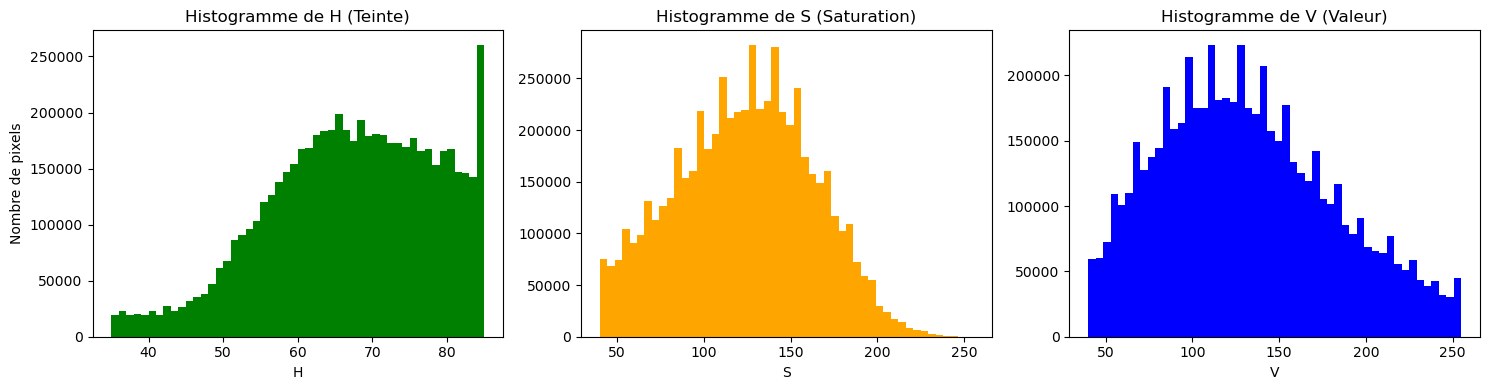

In [17]:
# Affichage des histogrammes
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(all_h, bins=50, color='green')
plt.title('Histogramme de H (Teinte)')
plt.xlabel('H')
plt.ylabel('Nombre de pixels')

plt.subplot(1, 3, 2)
plt.hist(all_s, bins=50, color='orange')
plt.title('Histogramme de S (Saturation)')
plt.xlabel('S')

plt.subplot(1, 3, 3)
plt.hist(all_v, bins=50, color='blue')
plt.title('Histogramme de V (Valeur)')
plt.xlabel('V')

plt.tight_layout()
plt.show()


**Interprétation :**  
La plage de couleur HSV, définie par les composantes suivantes :  
`vert_min = (30, 50, 50)` et `vert_max = (90, 225, 255)` 
permet de cibler précisément la gamme des teintes vertes présentes dans l’image.
.


### Étape 3: Extraction quantitative des caractéristiques spectrales HSV des pixels non verts dans les images de feuilles malades pour la détection précoce des symptômes phytopathologiques

In [12]:

# Dossier des images malades
folder_path = './Dataset_Préparer/Data_Train/Feuilles_Malades'
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Listes pour stocker les pixels non verts
all_h, all_s, all_v = [], [], []
sample_size = 5000  # Limite de pixels par image

print(f"\nNombre total d'images trouvées : {len(image_files)}\n")

for i, img_file in enumerate(image_files, 1):
    img_path = os.path.join(folder_path, img_file)
    try:
        img = Image.open(img_path).convert('RGB')
        print(f"[{i}/{len(image_files)}] Traitement de : {img_file}")
    except Exception as e:
        print(f"❌ Erreur de chargement pour {img_file} : {e}")
        continue

    # Redimensionnement
    img = img.resize((128, 128))

    # Conversion RGB → HSV
    img_hsv = img.convert('HSV')
    h, s, v = np.array(img_hsv).transpose(2, 0, 1)  # h, s, v séparés

    # Masque des pixels verts (valeurs H entre 35–85)
    mask_green = (h >= 35) & (h <= 85) & (s >= 40) & (v >= 40)
    mask_non_green = ~mask_green  # Inverse : les couleurs autres que vert

    # Extraire pixels non verts
    h_non_green = h[mask_non_green]
    s_non_green = s[mask_non_green]
    v_non_green = v[mask_non_green]

    # Limiter à un échantillon
    if len(h_non_green) > sample_size:
        indices = random.sample(range(len(h_non_green)), sample_size)
        h_non_green = h_non_green[indices]
        s_non_green = s_non_green[indices]
        v_non_green = v_non_green[indices]

    # Ajouter à la liste globale
    all_h.extend(h_non_green)
    all_s.extend(s_non_green)
    all_v.extend(v_non_green)

print("\n✅ Traitement terminé. Affichage des histogrammes...\n")

# Convertir en numpy arrays
all_h = np.array(all_h)
all_s = np.array(all_s)
all_v = np.array(all_v)



Nombre total d'images trouvées : 1305

[1/1305] Traitement de : Train_0.jpg
[2/1305] Traitement de : Train_1.jpg
[3/1305] Traitement de : Train_10.jpg
[4/1305] Traitement de : Train_1000.jpg
[5/1305] Traitement de : Train_1003.jpg
[6/1305] Traitement de : Train_1006.jpg
[7/1305] Traitement de : Train_1008.jpg
[8/1305] Traitement de : Train_1009.jpg
[9/1305] Traitement de : Train_101.jpg
[10/1305] Traitement de : Train_1010.jpg
[11/1305] Traitement de : Train_1011.jpg
[12/1305] Traitement de : Train_1013.jpg
[13/1305] Traitement de : Train_1015.jpg
[14/1305] Traitement de : Train_1016.jpg
[15/1305] Traitement de : Train_1018.jpg
[16/1305] Traitement de : Train_1019.jpg
[17/1305] Traitement de : Train_102.jpg
[18/1305] Traitement de : Train_1021.jpg
[19/1305] Traitement de : Train_1022.jpg
[20/1305] Traitement de : Train_1023.jpg
[21/1305] Traitement de : Train_1024.jpg
[22/1305] Traitement de : Train_1025.jpg
[23/1305] Traitement de : Train_1026.jpg
[24/1305] Traitement de : Train_1027

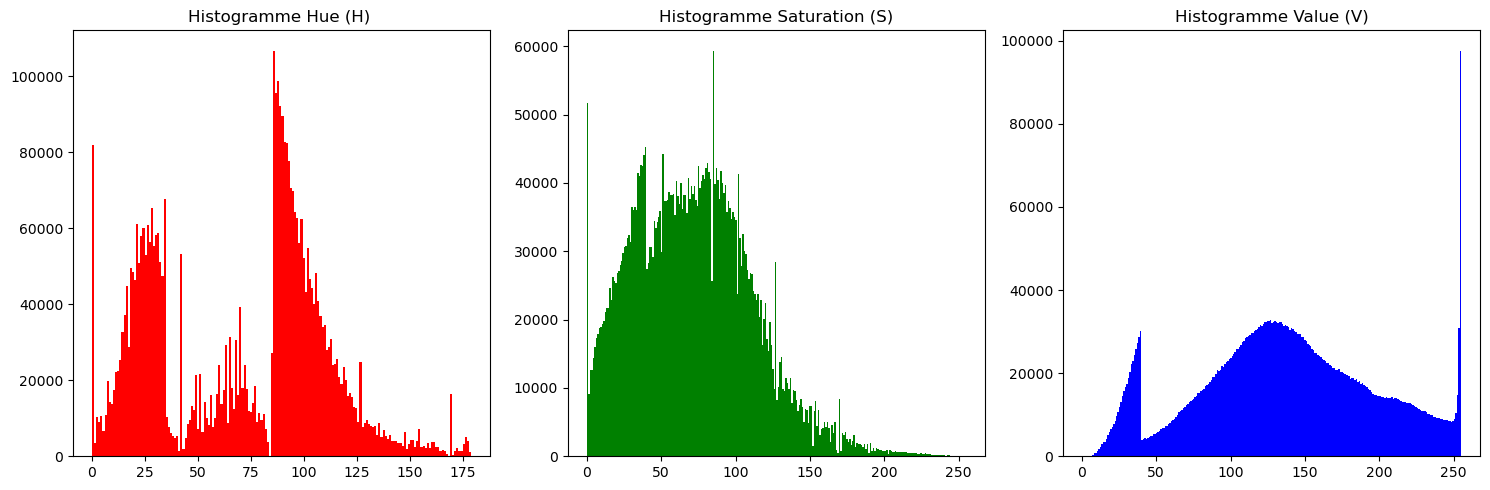

In [14]:
# Affichage des histogrammes HSV
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(all_h, bins=180, range=[0, 179], color='r')
plt.title('Histogramme Hue (H) ')

plt.subplot(1, 3, 2)
plt.hist(all_s, bins=256, range=[0, 255], color='g')
plt.title('Histogramme Saturation (S)')

plt.subplot(1, 3, 3)
plt.hist(all_v, bins=256, range=[0, 255], color='b')
plt.title('Histogramme Value (V)')

plt.tight_layout()
plt.show()


**Interprétation** :
Les zones malades semblent se caractériser par :

Des teintes variant entre rougeâtres-brunes (H : 0–30) et jaune-verdâtres (H : 90–130).

Une saturation moyenne (S : 30–120).

Une luminosité qui peut être soit assez faible (V : 30–50), soit moyenne à élevée (V : 100–180).

La plage HSV définie par les valeurs [10, 100, 50] à [30, 255, 255] est cohérente avec les distributions observées dans les histogrammes. Elle permet de capturer efficacement une proportion significative des zones malades, en particulier celles présentant des teintes rougeâtres,orangées ou brunâtres, associées à une saturation et une luminosité moyennes à élevées.

### Étape 4: Prétraitement  d’Images :Réduction de Bruit, Amélioration du Contraste  par CLAHE et Analyse par Histogrammes

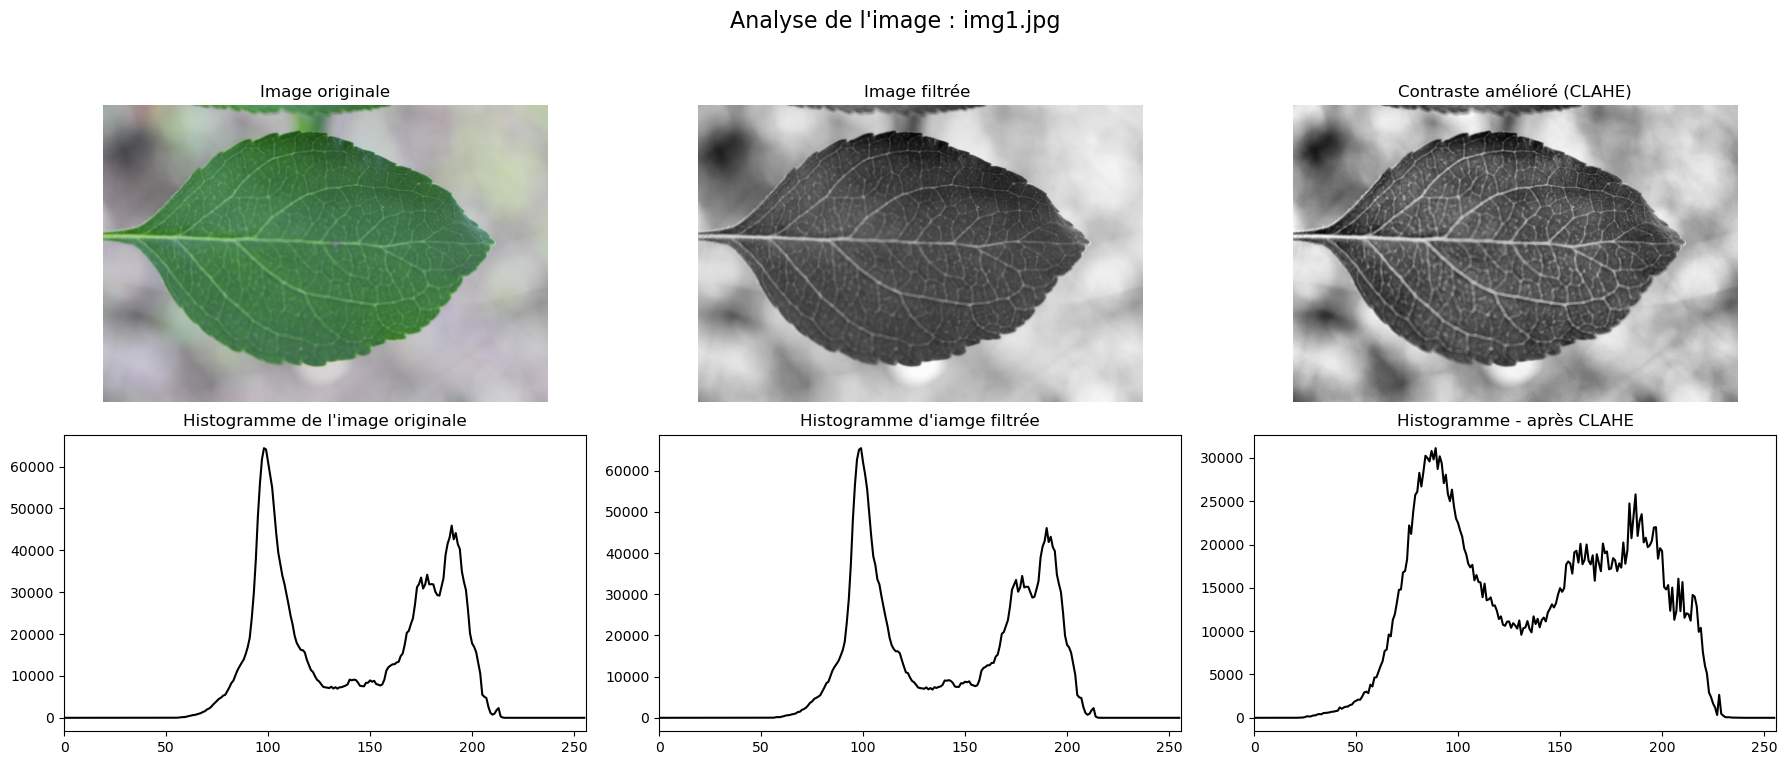

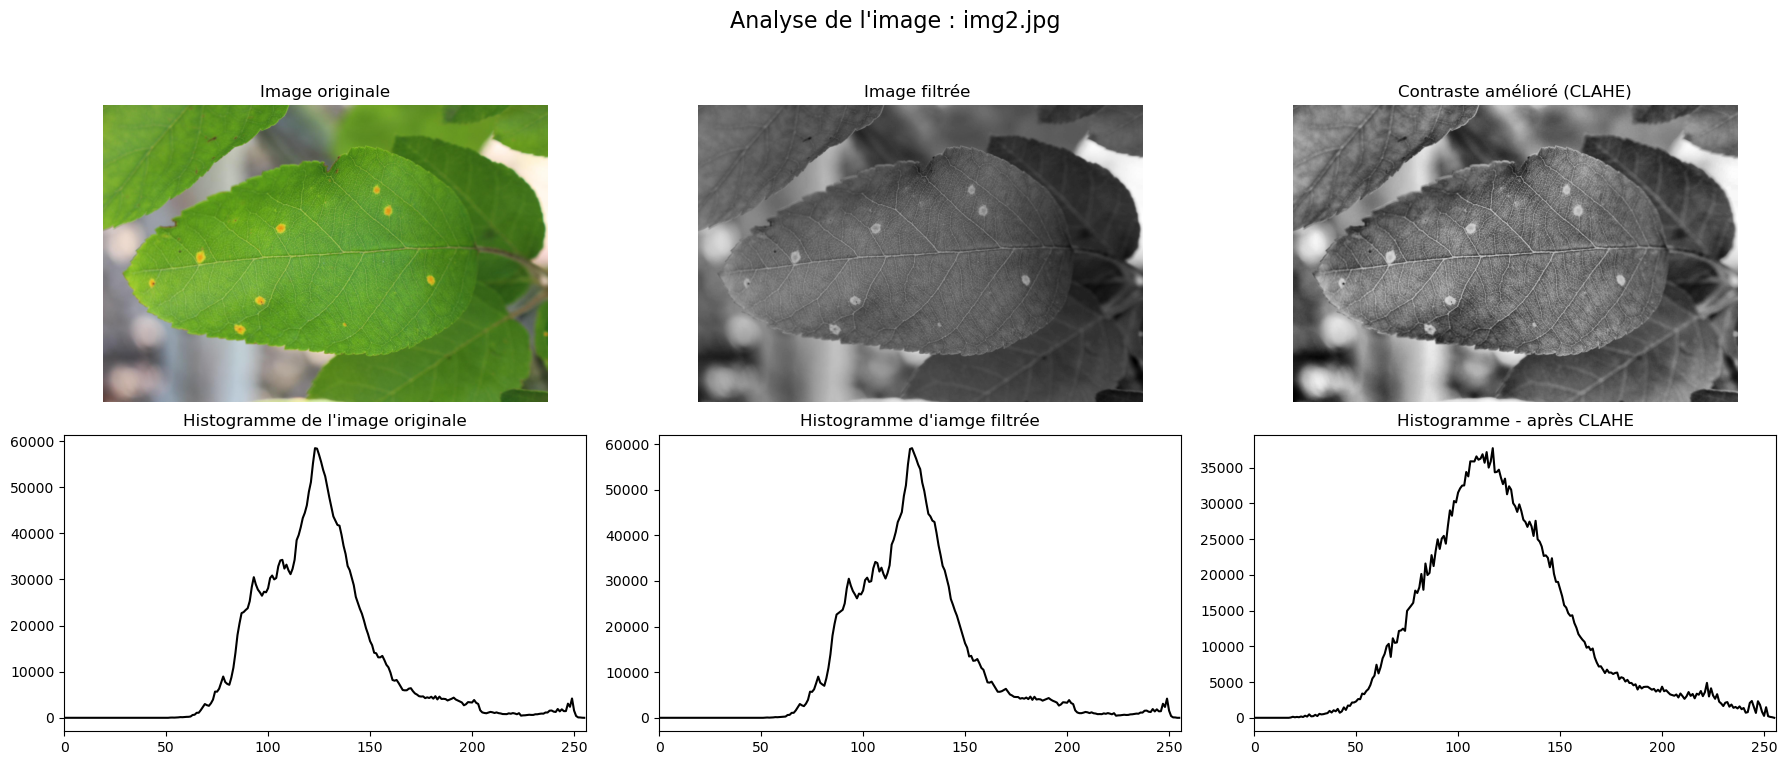

In [36]:

# Fonction de prétraitement d'une image : conversion, débruitage, amélioration du contraste et calcul des histogrammes
def preprocess_leaf_image(image_path):
    # 1. Charger l'image couleur et convertir en format RGB (utile pour affichage)
    rgb_image = Image.open(image_path).convert('RGB') 
    
    # 2. Convertir l'image RGB en niveaux de gris pour traitement
    gray_image = rgb_image.convert('L') 
    
    # 3. Convertir l'image en matrice NumPy (tableau 2D de pixels)
    array_image = np.array(gray_image)
    
    # 4. Réduire le bruit avec un filtre médian (taille du noyau = 3)
    filtered_image = cv2.medianBlur(array_image, ksize=3)
    
    # 5. Améliorer le contraste local avec CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced_image = clahe.apply(filtered_image)
    
    # 6. Calculer les histogrammes des différentes versions de l’image (original, filtrée, contrastée)
    hist_original = np.histogram(array_image.flatten(), bins=256, range=(0, 256))[0]
    hist_filtered = np.histogram(filtered_image.flatten(), bins=256, range=(0, 256))[0]
    hist_contrasted = np.histogram(contrast_enhanced_image.flatten(), bins=256, range=(0, 256))[0]
    
    # 7. Retourner les images et leurs histogrammes pour analyse et affichage
    return np.array(rgb_image), array_image, filtered_image, contrast_enhanced_image, hist_original, hist_filtered, hist_contrasted

# Liste des chemins vers les images à traiter
image_files = ['./IMG/img1.jpg', './IMG/img2.jpg']
image_titles = ['img1.jpg', 'img2.jpg']

# Boucle sur chaque image pour appliquer le traitement et afficher les résultats
for index, image_path in enumerate(image_files):
    # 1. Appliquer le prétraitement à l'image : chargement, débruitage, amélioration contraste, calcul histogrammes
    img_rgb, img_array, img_filtered, img_contrasted, hist_orig, hist_filt, hist_contrast = preprocess_leaf_image(image_path)
    
    # 2. Créer une fenêtre graphique pour afficher images et histogrammes
    plt.figure(figsize=(18, 8))
    plt.suptitle(f"Analyse de l'image : {image_titles[index]}", fontsize=16)

    # 3. Afficher l'image couleur originale (RGB)
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Image originale")
    plt.axis('off')

    # 4. Afficher l'image après application du filtre médian (réduction du bruit)
    plt.subplot(2, 3, 2)
    plt.imshow(img_filtered, cmap='gray')
    plt.title("Image filtrée ")
    plt.axis('off')
    
    # 5. Afficher l'image après amélioration locale du contraste (CLAHE)
    plt.subplot(2, 3, 3)
    plt.imshow(img_contrasted, cmap='gray')
    plt.title("Contraste amélioré (CLAHE)")
    plt.axis('off')

    # 6. Afficher l'histogramme de l'image en niveaux de gris originale
    plt.subplot(2, 3, 4)
    plt.plot(hist_orig, color='black')
    plt.title("Histogramme de l'image originale")
    plt.xlim([0, 256])

    # 7. Afficher l'histogramme après application du filtre médian
    plt.subplot(2, 3, 5)
    plt.plot(hist_filt, color='black')
    plt.title("Histogramme d'iamge filtrée")
    plt.xlim([0, 256])

    # 8. Afficher l'histogramme après amélioration du contraste avec CLAHE
    plt.subplot(2, 3, 6)
    plt.plot(hist_contrast, color='black')
    plt.title("Histogramme - après CLAHE")
    plt.xlim([0, 256])

    # 9. Ajuster la mise en page et afficher tous les graphiques
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Étape 5: Analyse Visuelle des Contours : Réduction de Bruit, Détection par Canny et Affichage des Contours sur les images¶

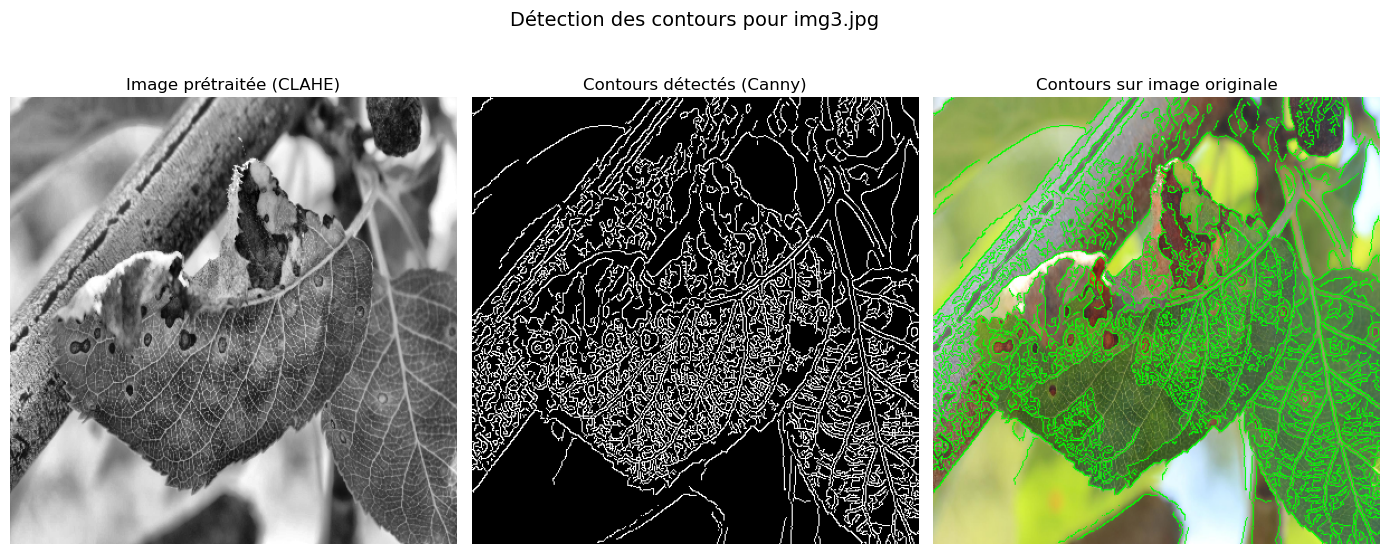

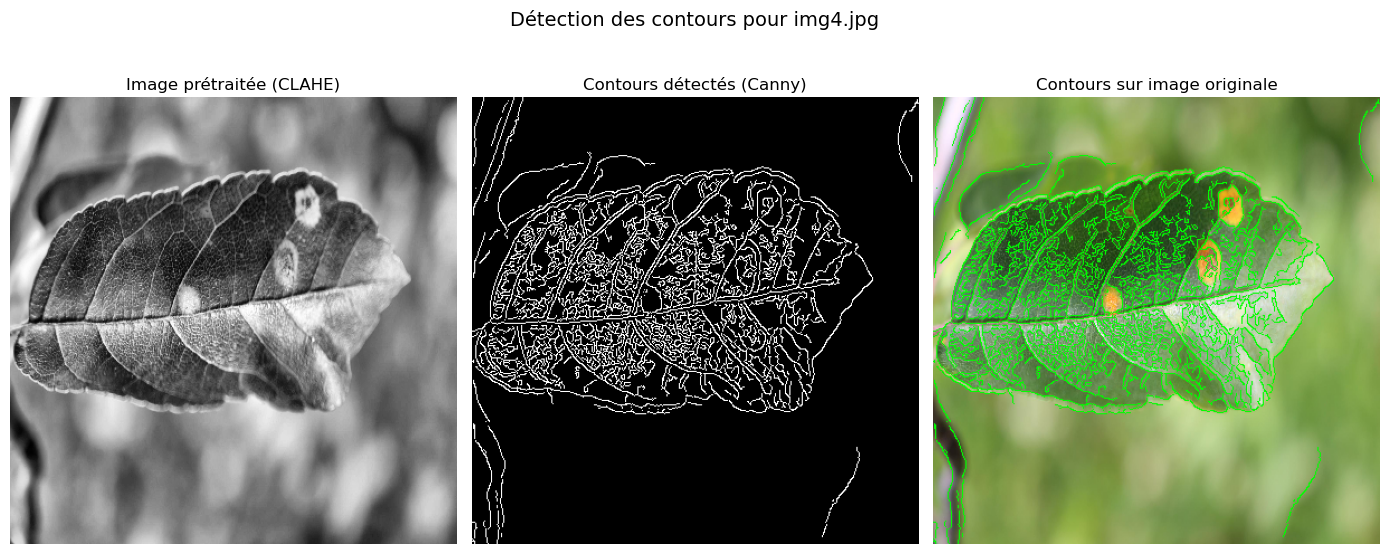

In [39]:

# Liste des images à traiter
image_paths = ['./IMG/img3.jpg', './IMG/img4.jpg']
titles = ['img3.jpg', 'img4.jpg']

# Boucle sur chaque image
for idx, path in enumerate(image_paths):
    # 1. Charger l’image
    image = cv2.imread(path)
    if image is None:
        print(f"Erreur : l'image '{path}' n'a pas été trouvée.")
        continue

    # 2. Redimensionner si nécessaire
    image = cv2.resize(image, (400, 400))

    # 3. Convertir en niveaux de gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 4. Appliquer CLAHE pour améliorer le contraste localement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)

    # 5. Réduction de bruit avec flou gaussien
    flou_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # 6. Détection de contours avec Canny
    edges = cv2.Canny(flou_image, threshold1=30, threshold2=100)

    # 7. Extraire les contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_image = image.copy()
    cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 1)

    # 8. Affichage
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Détection des contours pour {titles[idx]}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(clahe_image, cmap='gray')
    plt.title("Image prétraitée (CLAHE)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Contours détectés (Canny)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
    plt.title("Contours sur image originale")
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Étape 6: Détection des zones non-vertes correspondent à des parties malades sur feuilles via la segmentation couleur HSV 

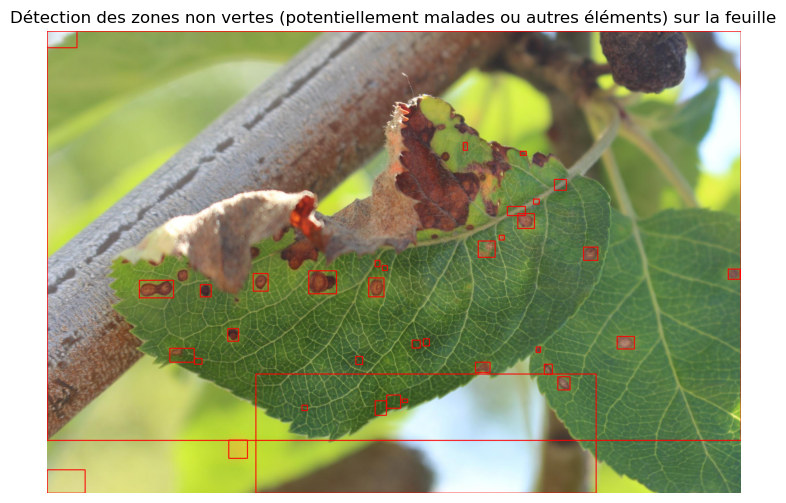

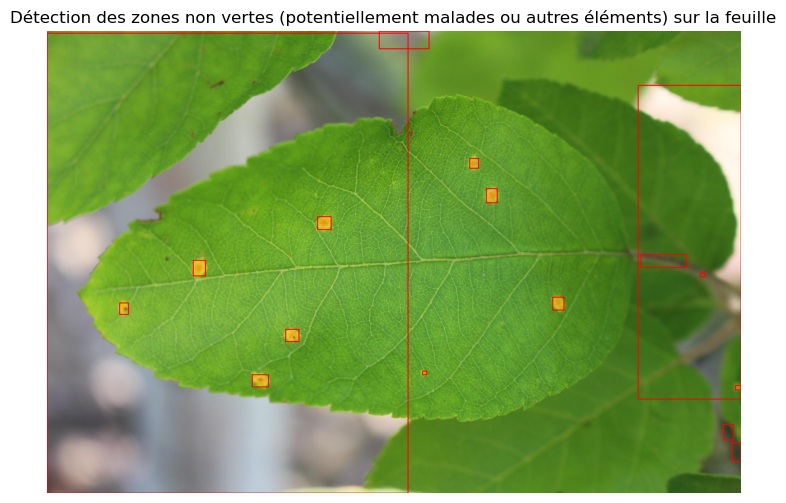

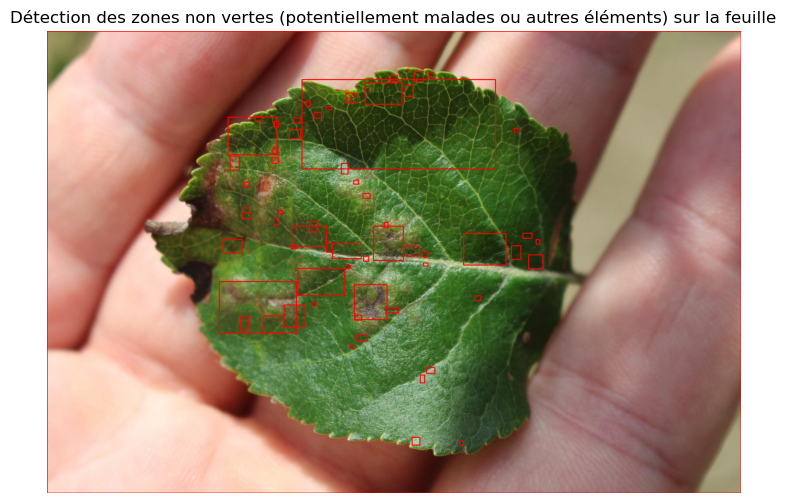

In [21]:

# Liste des images à traiter
image_paths = ['./IMG/img3.jpg', './IMG/img2.jpg', './IMG/img7.jpg']
titles = ['img3.jpg', 'img2.jpg', 'img7.jpg']

for idx, path in enumerate(image_paths):
    # 1. Charger l'image
    image = cv2.imread(path)
    if image is None:
        print(f"Erreur : l'image '{path}' n'a pas été trouvée.")
        continue

    # 2. Convertir l'image en HSV pour segmentation couleur
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 3. Amélioration locale du contraste sur la composante V (luminosité) avec CLAHE
    h, s, v = cv2.split(gray_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_clahe = clahe.apply(v)
    gray_image_clahe = cv2.merge([h, s, v_clahe])

    # 4. Définir la plage des verts 
    vert_min = np.array([30, 50, 50])
    vert_max = np.array([90, 255, 255])

    # 5. Créer un masque isolant les zones vertes (création d'un masque binaire où les pixels verts sont mis à 1 (blanc) et les autres à 0 (noir))

    masque_vert = cv2.inRange(gray_image_clahe, vert_min, vert_max)

    # 6. Inverser masque pour détecter zones non-vertes (ces zones peuvent correspondre à des parties malades, décolorées, ou autre défaut:des objets
    # comme une main, des branches, un fond, etc )
   
    masque_non_vert = cv2.bitwise_not(masque_vert)

    # 7. Réduction du bruit sur le masque non-vert avec un filtre morphologique
    kernel = np.ones((3,3), np.uint8)
    masque_nettoye = cv2.morphologyEx(masque_non_vert, cv2.MORPH_OPEN, kernel, iterations=2)
    masque_nettoye = cv2.morphologyEx(masque_nettoye, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 8. Segmentation des régions connectées dans le masque nettoyé
    nb_labels, etiquettes, stats, centroids = cv2.connectedComponentsWithStats(masque_nettoye, connectivity=8)

    # 9. Filtrer les zones suspectes selon la surface
    zones_maladie = []
    for i in range(1, nb_labels):  # on ignore l'étiquette 0 (background)
        x, y, l, h, surface = stats[i]
        if surface > 100:  # Seuil pour éliminer petites zones parasites
            zones_maladie.append((x, y, l, h))

    # 10. Dessiner des rectangles rouges sur les zones suspectes sur l'image originale
    for (x, y, l, h) in zones_maladie:
        cv2.rectangle(image, (x, y), (x + l, y + h), (0, 0, 255), 2)

    # 11. Afficher le résultat
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Détection des zones non vertes (potentiellement malades ou autres éléments) sur la feuille")
    plt.axis('off')
    plt.show()


### Étape 7:Détection et Visualisation des Zones Anormales, pathologiques par Segmentation des Composantes Non-Vertes en HSV

In [36]:

# Liste des chemins des images à traiter
chemins_images = ['./IMG/img1.jpg', './IMG/img2.jpg', './IMG/img3.jpg']
titres_images = ['Image 1', 'Image 2', 'Image 3']

# Stockage des résultats pour affichage plus tard
resultats = []

for chemin, titre in zip(chemins_images, titres_images):
    image = cv2.imread(chemin)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    vert_min = np.array([25, 40, 40])
    vert_max = np.array([100, 255, 255])

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    masque_vert = cv2.inRange(hsv_image, vert_min, vert_max)

    masque_non_vert = cv2.bitwise_not(masque_vert)
    img_masquee = cv2.bitwise_and(image, image, mask=masque_non_vert)
    img_masquee_inversee = cv2.bitwise_not(img_masquee)

    # On stocke tout dans un dict
    resultats.append({
        'titre': titre,
        'image': image,
        'masque_vert': masque_vert,
        'masque_non_vert_inverse': img_masquee_inversee
    })


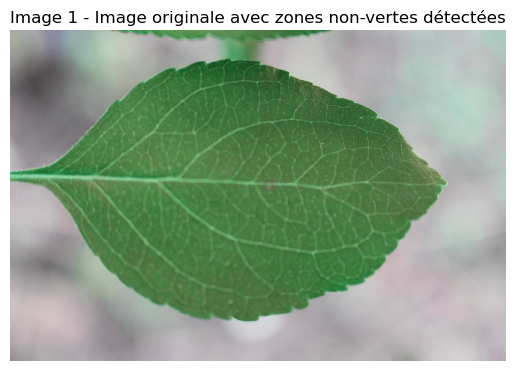

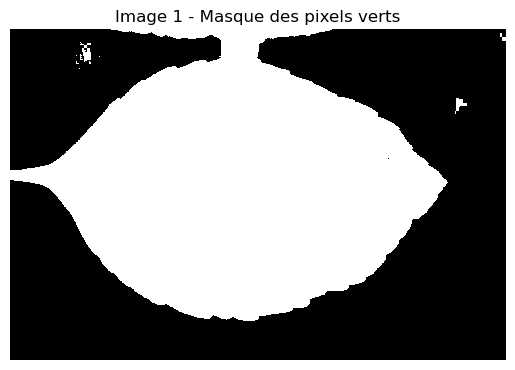

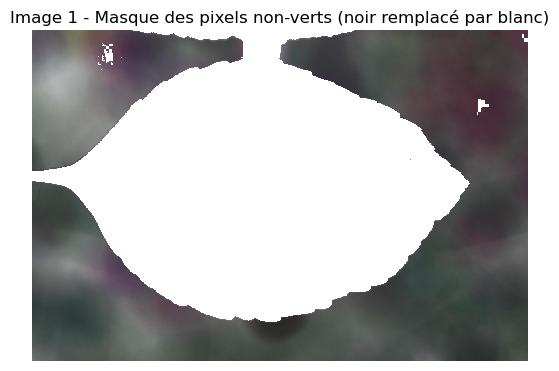

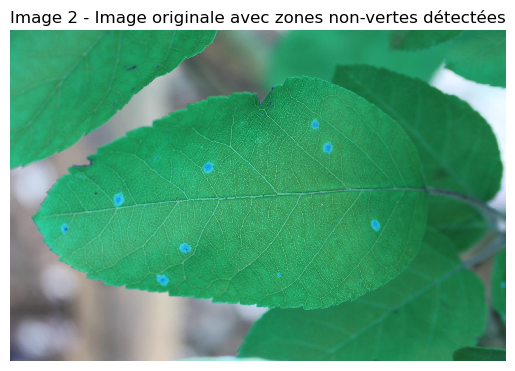

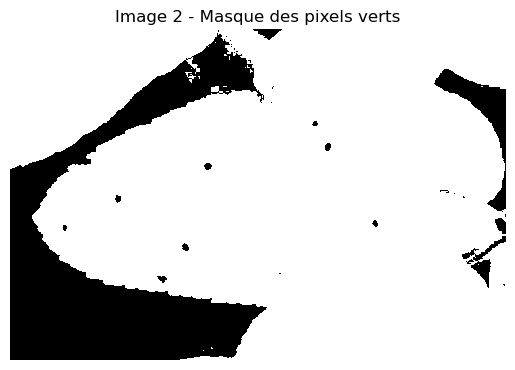

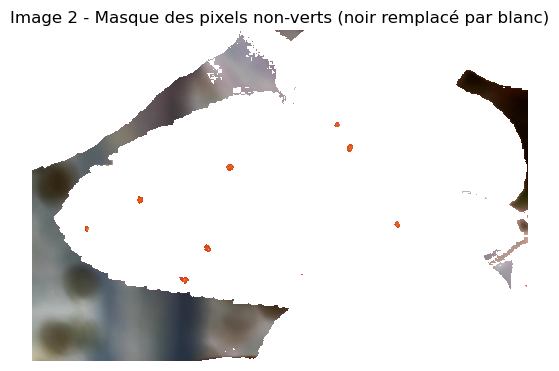

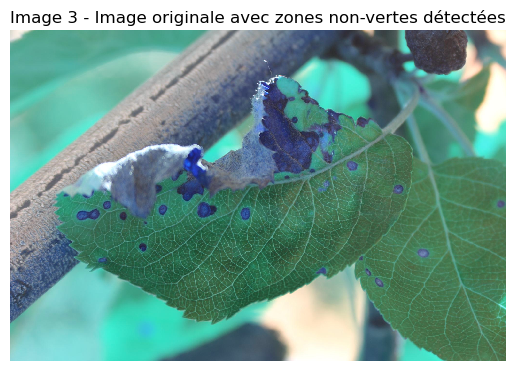

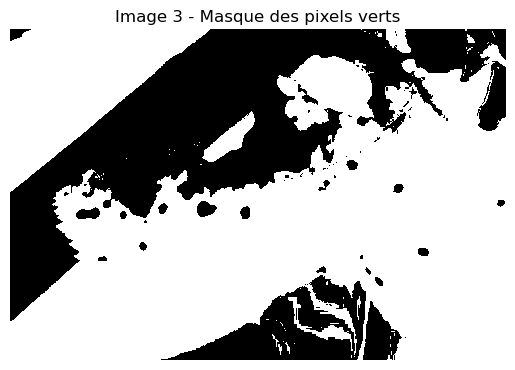

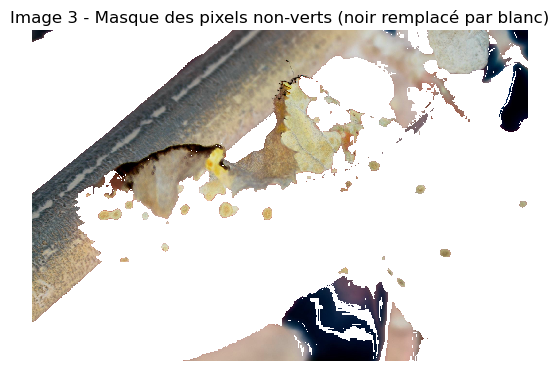

In [38]:

def afficher_image(image, titre="image"):
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.title(titre)
    plt.show()

# Affichage des résultats calculés
for res in resultats:
    afficher_image(res['image'], f"{res['titre']} - Image originale avec zones non-vertes détectées")
    afficher_image(res['masque_vert'], f"{res['titre']} - Masque des pixels verts")
    afficher_image(res['masque_non_vert_inverse'], f"{res['titre']} - Masque des pixels non-verts (noir remplacé par blanc)")


### Étape 8: Détection des zones suspectes de maladie sur les feuilles par segmentation des régions symptomatiques via l'extraction morphologique et filtrage selon la texture et la forme des zones

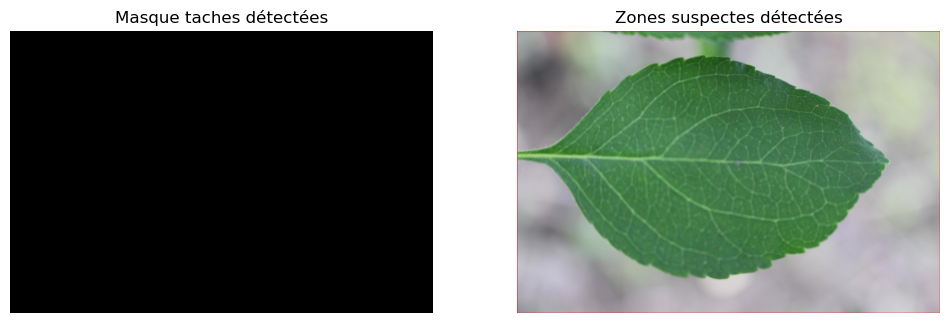

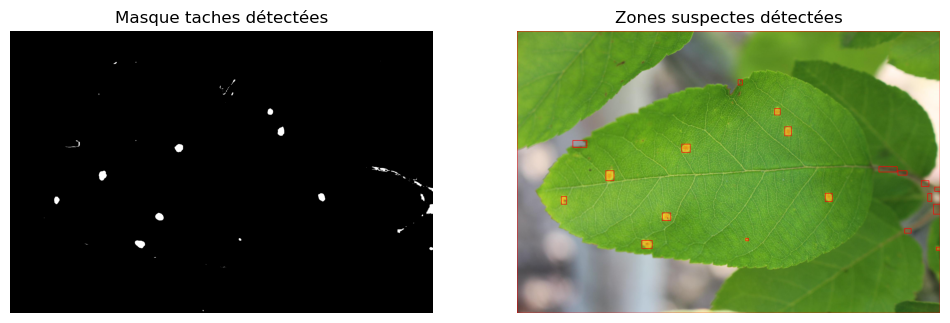

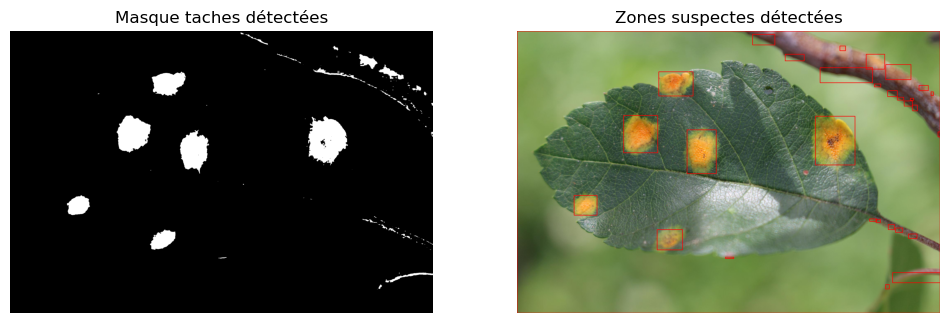

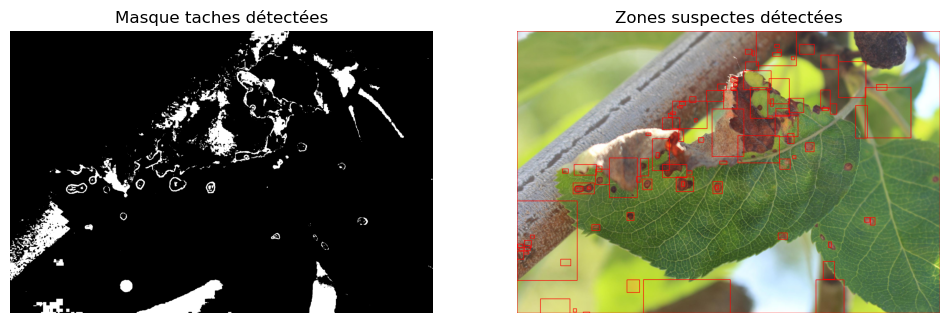

In [44]:
# Liste des images à traiter
image_paths = ['./IMG/img1.jpg', './IMG/img2.jpg', './IMG/img5.jpg','./IMG/img3.jpg']
titles = ['img1.jpg', 'img2.jpg', 'img5.jpg','img3.jpg']
min_surface_zone = 100  # Taille minimale pour zone suspecte

for idx, path in enumerate(image_paths):
    # 1. Chargement de l’image
    image = cv2.imread(path)
    if image is None:
        print(f"Erreur : l'image '{path}' est introuvable.")
        continue

    # 2. Conversion en niveaux de gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 3. Amélioration locale du contraste (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray_image)

    # 4. Réduction du bruit par flou gaussien
    flou_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)

    # 5. Soustraction de fond (MOG2) pour isoler feuille/taches
    back_sub = cv2.createBackgroundSubtractorMOG2()
    fg_mask = back_sub.apply(flou_image)

    # 6. Nettoyage du masque par ouverture puis fermeture morphologique
    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # 7. Extraction de l’avant-plan en couleur
    img_fg = cv2.bitwise_and(image, image, mask=mask_clean)

    # 8. Conversion en HSV pour détection couleur taches
    gray_image = cv2.cvtColor(img_fg, cv2.COLOR_BGR2HSV)

       # 9. Définition des plages couleurs pour différentes taches
    plages_couleurs = {
        'zones_malades': ([10, 100, 50], [30, 255, 255]),   
    }
    # 10. Création d’un masque combiné pour toutes les taches
    masque_taches = np.zeros(gray_image.shape[:2], dtype=np.uint8)
    for key, (lower, upper) in plages_couleurs.items():
        lower_np = np.array(lower)
        upper_np = np.array(upper)
        masque_couleur = cv2.inRange(gray_image, lower_np, upper_np)
        masque_taches = cv2.bitwise_or(masque_taches, masque_couleur)

    # 11. Étiquetage des régions taches
    _, labels, stats, _ = cv2.connectedComponentsWithStats(masque_taches, 8)

    # 12. Filtrage et stockage des zones suspectes
    zones_suspectes = []
    for stat in stats:
        surface = stat[4]
        if surface > min_surface_zone:
            x, y, largeur, hauteur = stat[:4]
            zones_suspectes.append((x, y, largeur, hauteur))

    # 13. Dessin des rectangles sur l’image originale
    for (x, y, l, h) in zones_suspectes:
        cv2.rectangle(image, (x, y), (x + l, y + h), (0, 0, 255), 2)

    # 14. Affichage des résultats
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Masque taches détectées")
    plt.imshow(masque_taches, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Zones suspectes détectées")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
